In [ ]:
from tool import *
warnings.filterwarnings("ignore")


# albedo

In [ ]:

fs=glob('/data/hk/albedo/landcover/2*/*-*')
for f in fs:
    os.remove(f)

In [ ]:
#检查文件像元大小
for y,m in[[2001,1],[2020,1]]:
    print('*'*20,y,m,'*'*20)
    # /data/hk/albedo/albedo/2020_1_albedo/
    fs=glob(f'/data/hk/albedo/albedo/{y}_{m}_albedo/{y}_{m}-*.tif')
    print(len(fs))
    for f in fs:
        ds=gdal.Open(f)
        if ds.GetGeoTransform()[1]!=0.004491576420597608:
            print(f)

In [ ]:
#拼接
#run splice.py
y=2001
m=2
print(y,m)
fs=glob(f'/data/hk/albedo/{y}_{m}_albedo2/{y}_{m}*.tif')
for i in range(1,15):
    print('-'*20,i,'-'*20)
    time.sleep(1)
    splice(fs,f'/data/hk/albedo/{y}_{m}_albedo2/{y}_{m}_band{i}.tif',pixel_size=0.004491576420597608,band_num=i,type='int32')

In [ ]:
#删除原文件
for y,m in[[2001,2],[2001,3],[2001,4],[2001,5],[2001,6],[2020,2],[2020,3],[2020,4],[2020,5],[2020,6]]:
    print('*'*20,y,m,'*'*20)
    fs=glob(f'/data/hk/albedo/{y}_{m}_albedo2/{y}_{m}-*.tif')
    for f in fs:
        os.remove(f)

In [ ]:
#可视化检查
for y,m in[[2001,2],[2001,3],[2001,4],[2001,5],[2001,6],[2020,2],[2020,3],[2020,4],[2020,5],[2020,6]]:
    print('*'*20,y,m,'*'*20)
    img=get_img(y,m,'BSA_vis_snow',coord=None,path=None)
    plt.imshow(img)
    plt.colorbar()
    plt.show()

# landcover

In [ ]:
#修改landcover
from tool import *
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,1,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img
ys=[os.path.basename(i).split('_')[0] for i in glob(root_path+f"landcover/*_landcover/*_landcover.tif")]
ys.sort()
for y in ys:
    print(y)
    img=get_img(y,1,'landcover')
    img[31000:34000,70000:]=20
    path=root_path+f"landcover/{y}_landcover/{y}_landcover.tif"
    tif_save(img,path,global_trf)

for y in [2001,2003,2004,2005,2006,2007,2008,2009,2020]:
    path=f"/data/hk/albedo/landcover/{y}_landcover/{y}_landcover.tif"
    ds=gdal.Open(path)
    print(ds.GetGeoTransform())
    img=ds.ReadAsArray()
    print(img.shape)
    img[img==0]=20
    if y==2003:
        plt.imshow(img)
        plt.colorbar()
        plt.show()
    tif_save(img,path,global_trf,p='4326')

In [ ]:
# #计算每个grid的land面积
# for y in [2001,2003,2004,2005,2006,2007,2008,2009,2020]:
#     print(y)
#     time.sleep(1)
#     result={}
#     for lat in tqdm(range(90,-90,-1)):
#         for lon in range(-180,180):
#             result[str(lat)+','+str(lon)]=get_land_area(y,[lon,lat])
#     torch.save(result,f"/data/hk/albedo/landcover/{y}_landcover/{y}_landarea.pth")

# snow

In [ ]:
#月合成
for y in range(2011,2021):
    for m in range(1,13):
        _=monthly_snow_cover(y,m,True)


In [ ]:
#临近年依次fill nodata
for y in range(2001,2021):
    for m in range(1,13):
        fill_snow_cover(y,m,True)

In [ ]:
#临近月fill nodata
for y in range(2001,2021):
    for m in range(1,13):
        fill_snow_cover2(y,m)

In [ ]:
#IDW填充+平滑+重采样
from tool import *
for y in range(2011,2021):
    for m in range(1,13):
        c=str(y)+str(m).zfill(2)
        pp=f'/data/hk/albedo/snow/snow_monthly/{c}_fill2.npy'
        # print(pp)
        img=np.load(pp)

        for j in range(1):
            img[np.isnan(img)]=255
            img=img.astype(np.uint8)
            need_interp=(img==255)[24*100:-24*100].sum()
            print(need_interp)
            if need_interp!=0:
                # print(need_interp)
                out = fill.fillnodata(img, (img!=255),max_search_distance=20,smoothing_iterations=1)
                need_interp=(out==255)[24*100:-24*100].sum()
                if need_interp!=0:
                    
                    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
                    print(need_interp)
            else:
                break
        resample(out,pp.replace('_fill2.npy','.tif'))

# white/black sky

In [183]:
from tool import *
black_nir=get_wb_fraction_data('nbd')
white_nir=get_wb_fraction_data('ndd')
black_vis=get_wb_fraction_data('vbd')
white_vis=get_wb_fraction_data('vdd')
fn=white_nir[0]/(white_nir[0]+black_nir[0])
fv=white_vis[0]/(white_vis[0]+black_vis[0])
f_white=(fn+fv)/2
f_white_data=f_white.data
f_white_mask=f_white.mask
f_white_data[f_white_mask==1]=2
f_white_data[f_white_mask==1]=2
ds=[resample_wb_fraction(f_white_data[i]) for i in range(240)]
f_white_resample=np.stack(ds)
torch.save(f_white_resample,root_path+'white_sky_fraction/white_sky_fraction.pth')

# SW

In [ ]:
from tool import *
for y in [2018,2019,2020]:
    for m in range(1,13):
        ds=gdal.Open(f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW.tif")
        ds.GetGeoTransform()
        img=ds.ReadAsArray()
        img2=np.mean(img.reshape(180,10,360,10).transpose(0,2,1,3).reshape(180,360,-1),axis=-1)
        torch.save(img2,f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW_1degree.tif")

In [27]:
for m in range(1,13):
    yy=[]
    for y in range(2001,2021):
        yy.append(torch.load(f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW_1degree.tif"))
    yy=np.mean(np.stack(yy),axis=0)
    torch.save(yy,f"/data/hk/albedo/SW_MERRA2/{m}_SW_1degree.tif")

# grid albedo

In [ ]:
from tool import *
warnings.filterwarnings("ignore")

In [ ]:
cc=get_10lat_information(2001,1,50)
cc.get_10lat_information()

In [ ]:
#合并
from tool import *
fs=glob(root_path+'information/*.pth')
ys=list(set([os.path.basename(i).split('_')[1] for i in fs]))
ys.sort()

print(ys[:-1])
ys=['2004','2014','2015','2016','2017','2018']
for y in ys:
    for m in tqdm(range(1,13),desc=f' {y} '):
        fs_y=glob(root_path+f'information/result3_{y}_{m}_*0.pth')
        if len(fs_y)!=18:
            raise(f'ERROR {len(fs_y)}')
        k={}
        for i in range(len(fs_y)):
            k.update(torch.load(fs_y[i]))
        torch.save(k,root_path+f'information2/result3_{y}_{m}_all.pth')

In [ ]:
from tool import *
for month in range(1,13):
    convert_to_nc(month)

In [ ]:
#fill albedo
from tool import *
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
# landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
landtypes=['ocean']
for month in range(2,12):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r+')
    for type in landtypes:
        v_fill,dws=fill_albedo(month,type)
        NC.createVariable(f'DWS-{type}', 'f4', ("time", "latitude", "longitude"))
        NC.variables[f'DWS-{type}'][:]=dws
        for band_i in range(len(bands)):
            NC.variables[f'{bands[band_i]}-{type}'][:]=v_fill[band_i]
    NC.close()


# Confuse Matrix

In [ ]:
get_10lat_confusionmatrix(y,m,40)

# visiable

In [ ]:
#短波辐射年际变化
z=[]
for y in range(2001,2021):
    zz=0
    for m in range(1,13):
        zz+=torch.load(f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW_1degree.tif").sum()
    z.append(zz)
plt.plot(z)
    
        
    

In [6]:
#单位是1
from tool import *
WB_sky_fraction=torch.load("/data/hk/albedo/white_sky_fraction/white_sky_fraction.pth")
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
stat={}
for month in range(1,13):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
    for year in range(2001,2021):
        types_stat=[]
        types_stat_albedo=[]
        sw=torch.load(f"/data/hk/albedo/SW_MERRA2/{month}_SW_1degree.tif")
        for type in landtypes:
            now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
            month_time=(now+relativedelta(months=1)-now).total_seconds()
            bs=NC.variables[f'albedo_BSA_shortwave-{type}'][year-2001]
            ws=NC.variables[f'albedo_WSA_shortwave-{type}'][year-2001]
            area_type=NC.variables[f'area-{type}'][year-2001] 
            area_land=NC.variables[f'area-land'][year-2001] 
            wf=WB_sky_fraction[(year-2001)*12+month-1]
            # area=NC.variables['area-grid'][year-2001]
            types_stat.append((1-(ws*wf+bs*(1-wf))/1000)*area_type*1e6*sw*month_time)
            types_stat_albedo.append(((ws*wf+bs*(1-wf))/1000)*area_type)
                            #   (1-(ws*wf+bs*(1-wf))/1000)*area_type*1e6*month_time
            # types_stat.append((ws*wf+bs*(1-wf))*area_type)
        types_stat=np.stack(types_stat)
        types_stat_albedo=np.stack(types_stat_albedo)
        stat[f'{year}-{month}']=types_stat  
        stat[f'{year}-{month}-albedo']=types_stat_albedo
    NC.close()          
for year in range(2001,2021):
    year_stat=[]
    year_stat_albedo=[]
    for month in range(1,13):
        year_stat.append(stat[f'{year}-{month}'])
        year_stat_albedo.append(stat[f'{year}-{month}-albedo'])
    year_stat=np.stack(year_stat)
    year_stat=np.nansum(year_stat,axis=0)
    stat[year]=year_stat
    year_stat_albedo=np.stack(year_stat_albedo)
    year_stat_albedo=np.nanmean(year_stat_albedo,axis=0)
    stat[f'{year}-albedo']=year_stat_albedo
torch.save(stat,'/data/hk/albedo/stat_meansw.pth')


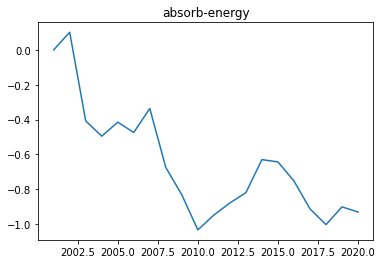

Net Radiative -0.9309885450486312
Integrated Net Radiative Energy Change -2.0892868806996284e+23


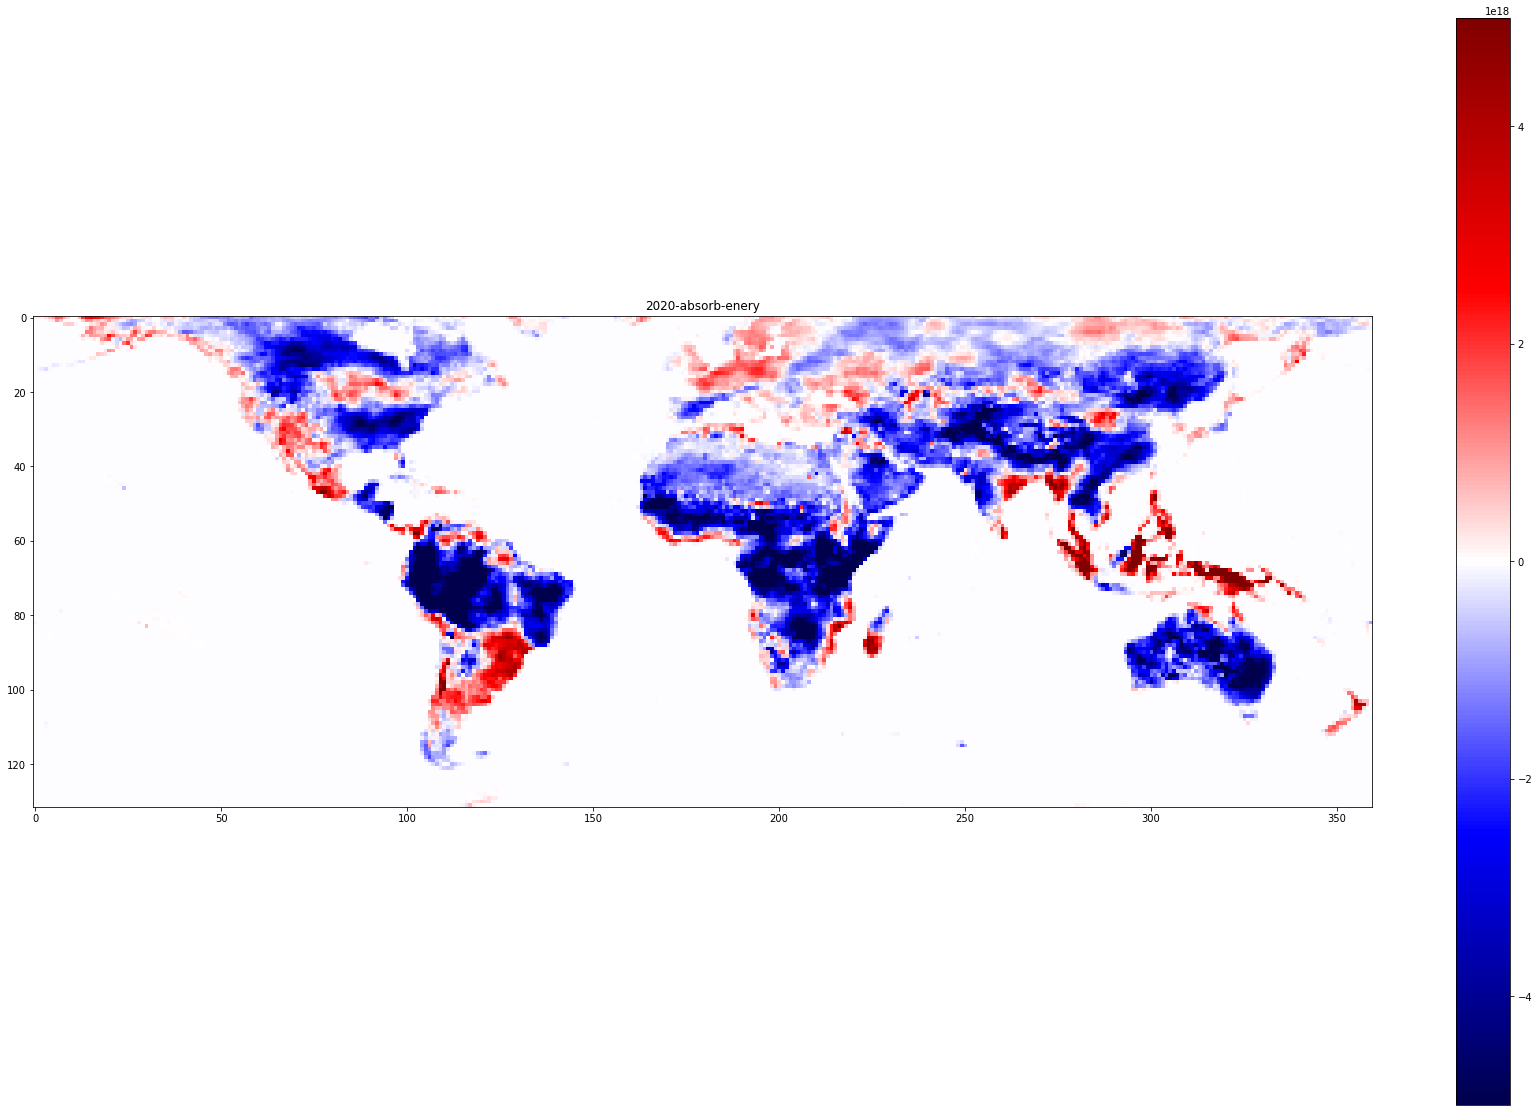

In [550]:

stat=torch.load('/data/hk/albedo/stat.pth')
kk=[]
stat_value={}
for year in range(2001,2021):

    kk.append(np.nansum(stat[year][:,24:-24]))
kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
plt.plot(range(2001,2021),[i/365/24/3600/5.1e8/1e6 for i in kk2])
plt.title('absorb-energy')
plt.show()
print('Net Radiative',(kk2[-1]-kk2[0])/365/24/3600/5.1e8/1e6)
print('Integrated Net Radiative Energy Change',np.array(kk2).sum())
baseline=np.nansum(stat[2001],axis=0)[24:-24,:]
for year in range(2020,2021):
    plt.figure(figsize=(30,20))
    plt.title(f'{year}-absorb-enery')
    plt.imshow(np.nansum(stat[year],axis=0)[24:-24,:]-baseline,vmax=5e18,vmin=-5e18,cmap='seismic')
    plt.colorbar()
    plt.show()

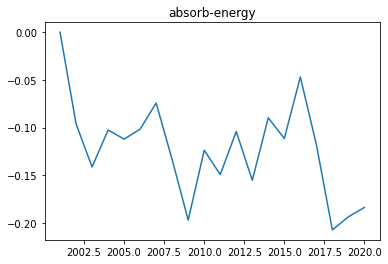

RF -0.18362783331583166
integrated RF -3.924134073395691e+22


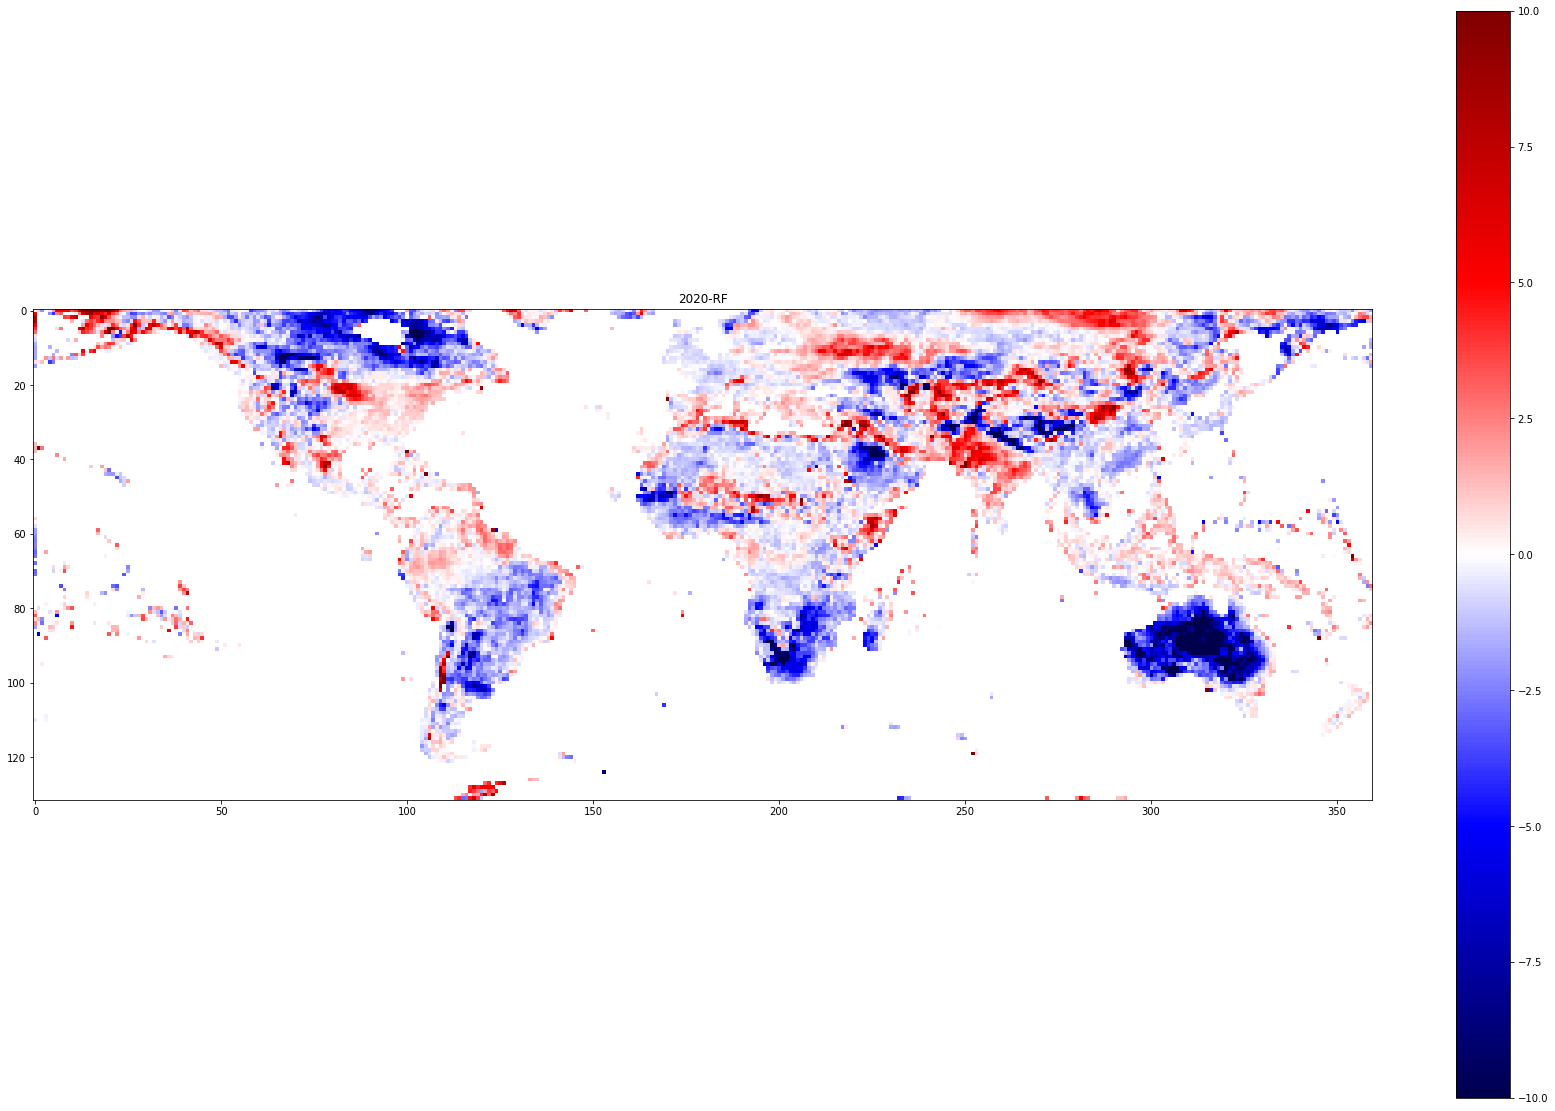

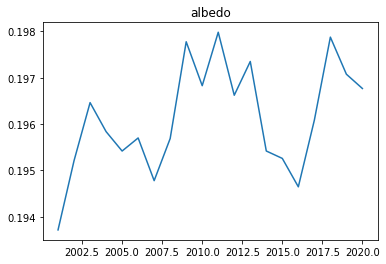

albedo
[0.19371519356146302, 0.1952117035555619, 0.1964632685236821, 0.19583706863603453, 0.19541815294502252, 0.19570038077445376, 0.1947786748979704, 0.19568870922508394, 0.19777723926589577, 0.19682875655550053, 0.19798266483523624, 0.19662255918330027, 0.19735147185561805, 0.19541889324572478, 0.19525881503216805, 0.19464557828234957, 0.1960842975684351, 0.19787721136285974, 0.1970765997799732, 0.19676813065330828]


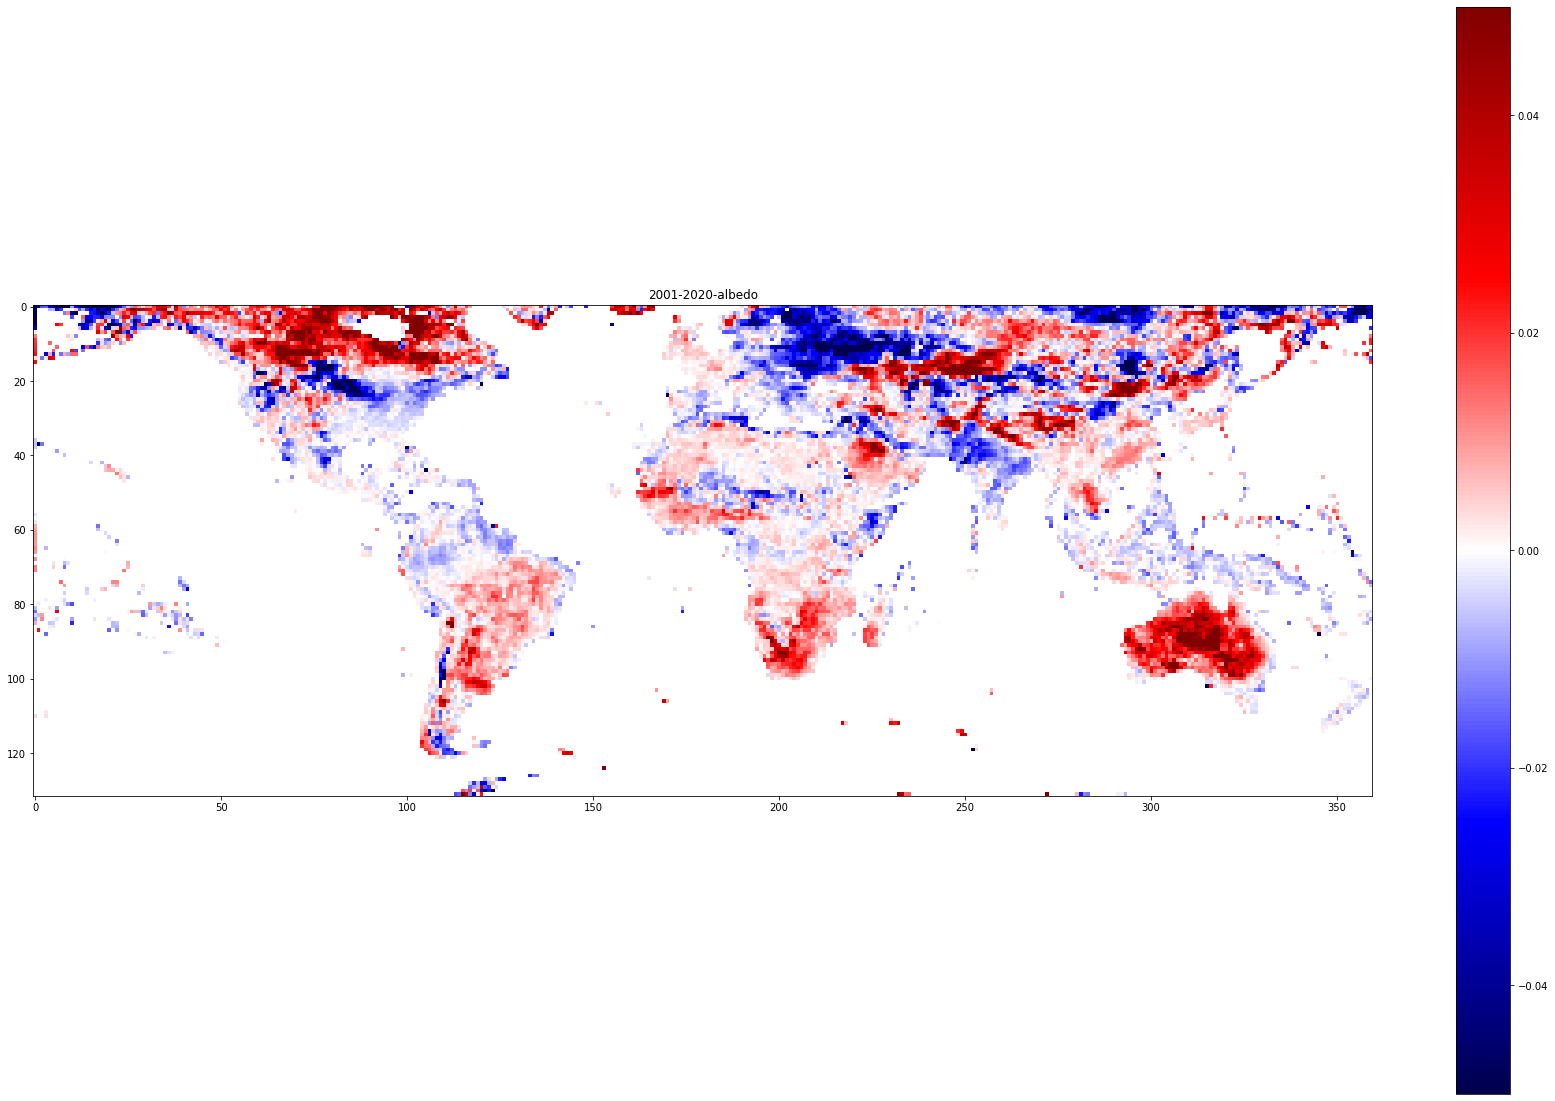

In [549]:
#辐射强迫
stat=torch.load('/data/hk/albedo/stat_meansw.pth')
kk=[]
stat_value={}
for year in range(2001,2021):

    kk.append(np.nansum(stat[year][:,24:-24]))
kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
plt.plot(range(2001,2021),[i/365/24/3600/5.1e8/1e6 for i in kk2])
plt.title('absorb-energy')
plt.show()
print('RF',(kk2[-1]-kk2[0])/365/24/3600/5.1e8/1e6)
print('integrated RF',np.array(kk2).sum())

end_y=2020
baseline_y=2001
NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
ll=NC.variables['area-land'][:][:,24:-24,:]
landarea_end=ll[end_y-2001]
landarea_baseline=ll[baseline_y-2001,:]
NC.close()


baseline=np.nansum(stat[baseline_y],axis=0)[24:-24,:]

plt.figure(figsize=(30,20))
plt.title(f'2020-RF')
plt.imshow((np.nansum(stat[end_y],axis=0)[24:-24,:]/landarea_end-baseline/landarea_baseline)/365/24/3600/1e6,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()



kk=[]
for y in range(2001,2021):
    mm=[]
    for m in range(1,13):
        a=np.nansum(stat[f'{y}-{m}-albedo'][:,24:-24,:],axis=0)
        a[a==0]=np.nan
        mm.append(a)
    ay=np.nanmean(np.stack(mm),axis=0)
    kk.append(np.nansum(ay)/126975430)
plt.plot(list(range(2001,2021)),kk)
plt.title('albedo')
plt.show()
print('albedo')
print(kk)


baseline_y=2001
mm=[]
for m in range(1,13):
    a=np.nansum(stat[f'{baseline_y}-{m}-albedo'][:,24:-24,:],axis=0)
    a[a==0]=np.nan
    mm.append(a)
baseline=np.nanmean(np.stack(mm),axis=0)
baseline[np.isnan(baseline)]=0

end_y=2020
mm=[]
for m in range(1,13):
    a=np.nansum(stat[f'{end_y}-{m}-albedo'][:,24:-24,:],axis=0)
    a[a==0]=np.nan
    mm.append(a)
end=np.nanmean(np.stack(mm),axis=0)
end[np.isnan(end)]=0
plt.figure(figsize=(30,20))
plt.title(f'{baseline_y}-{end_y}-albedo')
plt.imshow(end/landarea_end-baseline/landarea_baseline,vmax=0.05,vmin=-0.05,cmap='seismic')
plt.colorbar()
plt.show()

In [310]:
type_code={0:'EN_Forests',#Evergreen_Needleleaf_Forests
           1:'EB_Forests',#Evergreen_Broadleaf_Forests
           2:'DN_Forests',#Deciduous_Needleleaf_Forests
           3:'DB_Forests',#Deciduous_Broadleaf_Forests
           4:'M_Forests',#Mixed_Forests
           5:'C_Shrublands',#CLosed_Shrublands
           6:'O_Shrublands',#Open_Shrublands
           7:'W_Savannas',#Woody_Savannas
           8:'Savannas',
           9:'Grasslands',
           10:'Permanent_Wetlands',
           11:'Croplands',
           12:'Urban',
           13:'Cropland Natural_Mosaics',#Cropland/Natural_Vegetation_Mosaics
           14:'Permanent_Snow',
           15:'Barren',
           16:'Water_Bodies',
           17:'Snow'
           }

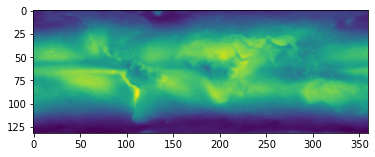

In [35]:
#SW分布
sw=[]
for month in range(1,13):
    sw.append(torch.load(f"/data/hk/albedo/SW_MERRA2/2016_{month}_SW_1degree.tif"))
sw=np.sum(np.stack(sw),axis=0)
plt.imshow(sw[24:-24,:])
plt.show()

In [38]:
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']

area=np.zeros((20,12,18))
for month in range(1,13):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
    for year in range(2001,2021):
        tt=0
        for type in landtypes:
            area_type=NC.variables[f'area-{type}'][year-2001]  
            area[year-2001,month-1,tt]=np.nansum(area_type[24:-24])
            tt+=1
    NC.close()  
# 面积变化
area_y=np.mean(area,axis=1)
p=0
print('面积占比        面积变化比例        面积变化值')
for t in range(18):
    print(type_code[t])
    print(area_y[0,t]/126975430*100,(area_y[-1,t]/area_y[0,t]-1)*100,(area_y[-1,t]-area_y[0,t])/10000)
    p+=area_y[0,t]/126975430*100

面积占比        面积变化比例        面积变化值
EN_Forests
1.7822570821378594 -4.125038558555927 -9.335080208333348
EB_Forests
10.024182959385659 -4.9520570035445965 -63.0310166666666
DN_Forests
0.28123758495049 -3.750931314527628 -1.3394674479166686
DB_Forests
2.1820409304120227 1.0958837280712785 3.0363166666666976
M_Forests
3.252989738513454 6.424029610233117 26.53443958333335
C_Shrublands
0.46006773055753114 -9.409312552720973 -5.496666145833325
O_Shrublands
7.340745896010485 2.3089427175667643 21.521525
W_Savannas
7.592255873176934 4.806727802704991 46.3382958333334
Savannas
11.36525848609714 -1.1383579764123852 -16.42774166666679
Grasslands
20.25924648046739 1.2016034769557926 30.91036666666679
Permanent_Wetlands
0.8671660106473615 3.7366169511199088 4.114343229166675
Croplands
8.391328083446274 3.781528289981151 40.2919
Urban
0.5765154107964037 9.519673028708354 6.9687140625
C/N_Mosaics
0.9579872722882949 13.428408076878506 16.334429166666673
Permanent_Snow
0.0 nan 0.0
Barren
15.49044317734016 

In [39]:
#雪面积与反照率相关系数（去趋势）
kk=[0.19371519356146302, 0.1952117035555619, 0.1964632685236821, 0.19583706863603453, 0.19541815294502252, 0.19570038077445376, 0.1947786748979704, 0.19568870922508394, 0.19777723926589577, 0.19682875655550053, 0.19798266483523624, 0.19662255918330027, 0.19735147185561805, 0.19541889324572478, 0.19525881503216805, 0.19464557828234957, 0.1960842975684351, 0.19787721136285974, 0.1970765997799732, 0.19676813065330828]
np.corrcoef([area_y[i+1,17]-area_y[i,17] for i in range(17)],[kk[i+1]-kk[i] for i in range(17)])

array([[1.        , 0.83512074],
       [0.83512074, 1.        ]])

In [40]:
#反照率变化
aaaa=[]
for t in range(18):
    kk=[]
    for y in range(2001,2021):
        mm=[]
        for m in range(1,13):
            a=np.nansum(stat[f'{y}-{m}-albedo'][t,24:-24,:],axis=0)/area[y-2001,m-1,t]
            a[a==0]=np.nan
            mm.append(a)
        ay=np.nanmean(np.stack(mm),axis=0)
        kk.append(np.nansum(ay))
    kk=[kk[i]for i in range(20)]
    aaaa.append((kk[-1]/kk[0]-1)*100)
    print(aaaa[t],kk[0],kk[-1],type_code[t])

2.806520462036133 0.112226516 0.115376174 EN_Forests
-1.6590297222137451 0.12083374 0.11882907 EB_Forests
-2.0672082901000977 0.15812507 0.1548563 DN_Forests
1.4287829399108887 0.12727743 0.12909596 DB_Forests
1.8993139266967773 0.12669182 0.12909809 M_Forests
10.308504104614258 0.12396167 0.13674027 C_Shrublands
9.125399589538574 0.17581104 0.1918545 O_Shrublands
3.352022171020508 0.13347064 0.13794461 W_Savannas
2.19876766204834 0.13794377 0.14097683 Savannas
3.029942512512207 0.16502398 0.17002411 Grasslands
0.4589200019836426 0.1299147 0.13051091 Permanent_Wetlands
2.998638153076172 0.15689203 0.16159666 Croplands
0.44476985931396484 0.14384976 0.14448956 Urban
1.736915111541748 0.147505 0.15006703 C/N_Mosaics
nan 0.0 0.0 Permanent_Snow
1.040971279144287 0.30139372 0.30453113 Barren
8.398795127868652 0.057269998 0.06207999 Water_Bodies
0.5182862281799316 0.4952549 0.49782175 Snow


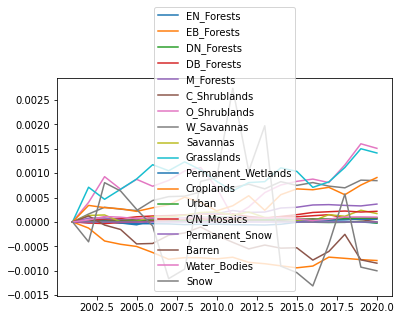

-2.2113776263644113e-05       -0.7243443149455164 EN_Forests
-0.000790828194084478       -25.903848336635228 EB_Forests
-2.1880678756118423e-05       -0.7167091262562925 DN_Forests
7.344506531696722e-05       2.405718267603591 DB_Forests
0.0003653671915109869       11.96772748730801 M_Forests
-3.6535119432167147e-07       -0.011967203493893337 C_Shrublands
0.001506989383694153       49.361953370067546 O_Shrublands
0.0008453308644042392       27.689101968796333 W_Savannas
0.00017079583821846649       5.594476174261223 Savannas
0.0014116983104526595       46.240661631170376 Grasslands
5.372840635389049e-05       1.7598923507924598 Permanent_Wetlands
0.0009089878648176272       29.774208818309315 Croplands
8.296560799203427e-05       2.717566903479433 Urban
0.00021716676801173274       7.113371860553884 C/N_Mosaics
0.0       0.0 Permanent_Snow
-0.0008452934555921582       -27.687876630345016 Barren
9.828931569674532e-05       3.2195001973439683 Water_Bodies
-0.001001351206292432       -32

In [41]:
zzzz=[]
w=[]
for t in range(18):
    kk=[]
    for y in range(2001,2021):
        mm=[]
        for m in range(1,13):
            a=np.nansum(stat[f'{y}-{m}-albedo'][t,24:-24,:],axis=0)
            a[a==0]=np.nan
            mm.append(a)
        ay=np.nanmean(np.stack(mm),axis=0)
        kk.append(np.nansum(ay)/126975430)
    w.append(np.array(kk).sum())
    kk=[kk[i]-kk[0] for i in range(20)]
    
    zzzz.append(kk[-1])
    plt.plot(list(range(2001,2021)),kk,label=type_code[t])
plt.legend()
plt.show()
#反照率变化的绝对贡献
for t in range(18):
    print(zzzz[t],'     ',zzzz[t]/0.003052937091845259*100,type_code[t])
    

In [42]:
#20年平均反照率权重
ww=w/np.array(w).sum()*100
for t in range(18):
    print(ww[t],type_code[t])

1.0138162602286938 EN_Forests
5.837442111413273 EB_Forests
0.23121619747286376 DN_Forests
1.466044756604289 DB_Forests
2.1639758892292207 M_Forests
0.30585941975231506 C_Shrublands
6.967484657666478 O_Shrublands
5.3854888600919955 W_Savannas
8.00613418819744 Savannas
17.46763951522425 Grasslands
0.5433782127493011 Permanent_Wetlands
6.938314586044875 Croplands
0.4424348066433828 Urban
0.7631662998472883 C/N_Mosaics
0.0 Permanent_Snow
23.60633497160127 Barren
0.6060623131750337 Water_Bodies
18.255206954058036 Snow


(array([ 0.25,  1.25,  2.25,  3.25,  4.25,  5.25,  6.25,  7.25,  8.25,
         9.25, 10.25, 11.25, 12.25, 13.25, 14.25, 15.25, 16.25, 17.25]),
 [Text(0.25, 0, 'EN_Forests'),
  Text(1.25, 0, 'EB_Forests'),
  Text(2.25, 0, 'DN_Forests'),
  Text(3.25, 0, 'DB_Forests'),
  Text(4.25, 0, 'M_Forests'),
  Text(5.25, 0, 'C_Shrublands'),
  Text(6.25, 0, 'O_Shrublands'),
  Text(7.25, 0, 'W_Savannas'),
  Text(8.25, 0, 'Savannas'),
  Text(9.25, 0, 'Grasslands'),
  Text(10.25, 0, 'Permanent_Wetlands'),
  Text(11.25, 0, 'Croplands'),
  Text(12.25, 0, 'Urban'),
  Text(13.25, 0, 'C/N_Mosaics'),
  Text(14.25, 0, 'Permanent_Snow'),
  Text(15.25, 0, 'Barren'),
  Text(16.25, 0, 'Water_Bodies'),
  Text(17.25, 0, 'Snow')])

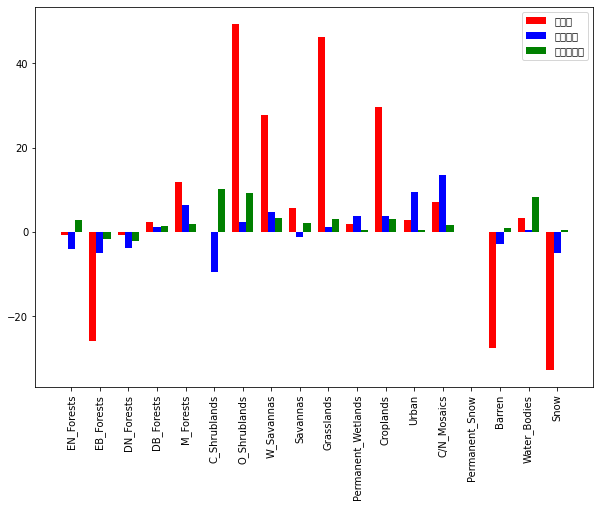

In [43]:
shops = [type_code[i] for i in range(18)]
sales_product_1 = [zzzz[t]/0.003052937091845259*100 for t in range(18)]
sales_product_2 = [(area_y[-1,t]/area_y[0,t]-1)*100 for t in range(18)]
sales_product_3 = [aaaa[t] for t in range(18)]

# 创建分组柱状图，需要自己控制x轴坐标
xticks = np.arange(len(shops))


fig, ax = plt.subplots(figsize=(10, 7))
# 所有门店第一种产品的销量，注意控制柱子的宽度，这里选择0.25
ax.bar(xticks, sales_product_1, width=0.25, label="贡献比", color="red")
# 所有门店第二种产品的销量，通过微调x轴坐标来调整新增柱子的位置
ax.bar(xticks + 0.25, sales_product_2, width=0.25, label="面积变化", color="blue")
# 所有门店第三种产品的销量，继续微调x轴坐标调整新增柱子的位置
ax.bar(xticks + 0.5, sales_product_3, width=0.25, label="反照率变化", color="green")
ax.legend()
ax.set_xticks(xticks + 0.25)
ax.set_xticklabels(shops)
plt.xticks(rotation=90)
plt.show()

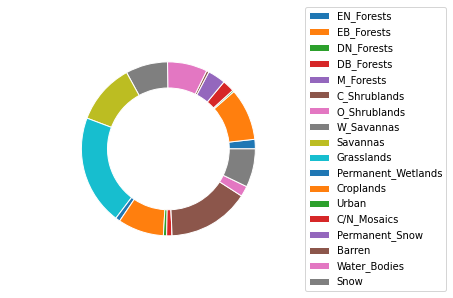

In [44]:
#面积占比
aa=np.mean(area_y,axis=0)
aa=aa/aa.sum()
l=[type_code[i] for i in range(18)]
plt.pie(aa,labels=l,
         textprops=dict(color='w'),wedgeprops=dict(width=0.3,edgecolor='w'))
# plt.pie(ww,labels=l,
#          radius=0.7,wedgeprops=dict(width=0.3,edgecolor='w'),textprops={'size':"smaller"})


 
plt.legend(labels=l,loc="right",bbox_to_anchor=(1.5,0,0.3,1))
plt.show()

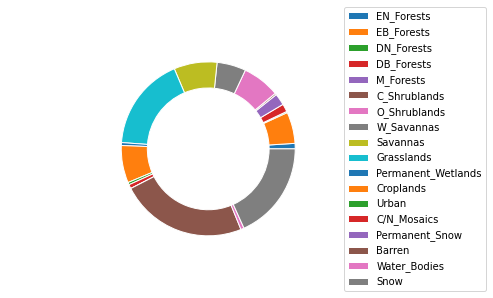

In [45]:
#反照率权重占比
l=[type_code[i] for i in range(18)]
plt.pie(ww,labels=l,
         textprops=dict(color='w'),wedgeprops=dict(width=0.3,edgecolor='w'))
# plt.pie(ww,labels=l,
#          radius=0.7,wedgeprops=dict(width=0.3,edgecolor='w'),textprops={'size':"smaller"})


 
plt.legend(labels=l,loc="right",bbox_to_anchor=(1.5,0,0.3,1))
plt.show()

In [ ]:
#O_Shrublands
NC=nc.Dataset(root_path+f'information_fill/month_1.nc','r')
land=NC.variables['area-landtype7'][:]
NC.close()
plt.imshow(land[0])

In [ ]:
#Barren
NC=nc.Dataset(root_path+f'information_fill/month_1.nc','r')
land=NC.variables['area-landtype16'][:]
NC.close()
plt.imshow(land[0])

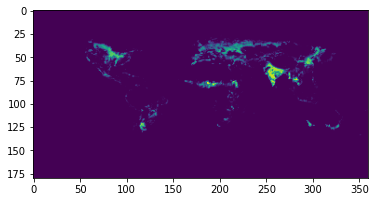

In [81]:
#Croplands
NC=nc.Dataset(root_path+f'information_fill/month_6.nc','r')
land=NC.variables['area-landtype12'][:]
NC.close()
plt.imshow(land[0])

# confuse matrix

In [ ]:
#合并
for y in range(2002,2021):
    for m in range(1,13):
        all={}
        for p in glob(f'/data/hk/albedo/confuse_matrix/result2_{y}_{m}_*.pth'):
            all.update(torch.load(p))
        print(y,m,len(all.keys()))
        torch.save(all,f'/data/hk/albedo/confuse_matrix/result2_{y}_{m}_all.pth')

In [290]:
#转换成矩阵
for year in range(2002,2021):
    print(year)
    data_m=[]
    for month in range(1,13):
        # print(month)
        data_m.append(convert_to_matrix(year,month))
    data_m=np.stack(data_m)
    torch.save(data_m,f'/data/hk/albedo/confuse_matrix/confuse_matrix_{year}.pth')

2002


100%|██████████| 180/180 [00:00<00:00, 420.02it/s]


2003


100%|██████████| 180/180 [00:00<00:00, 417.81it/s]


2004


100%|██████████| 180/180 [00:00<00:00, 419.54it/s]


2005


100%|██████████| 180/180 [00:00<00:00, 404.15it/s]


2006


100%|██████████| 180/180 [00:00<00:00, 419.61it/s]


2007


100%|██████████| 180/180 [00:00<00:00, 420.62it/s]


2008


100%|██████████| 180/180 [00:00<00:00, 414.69it/s]


2009


100%|██████████| 180/180 [00:00<00:00, 419.81it/s]


2010


100%|██████████| 180/180 [00:00<00:00, 422.31it/s]


2011


100%|██████████| 180/180 [00:00<00:00, 423.38it/s]


2012


100%|██████████| 180/180 [00:00<00:00, 433.30it/s]


2013


100%|██████████| 180/180 [00:00<00:00, 424.24it/s]


2014


100%|██████████| 180/180 [00:00<00:00, 414.90it/s]


2015


100%|██████████| 180/180 [00:00<00:00, 428.29it/s]


2016


100%|██████████| 180/180 [00:00<00:00, 416.21it/s]


2017


100%|██████████| 180/180 [00:00<00:00, 424.67it/s]


2018


100%|██████████| 180/180 [00:00<00:00, 423.78it/s]


2019


100%|██████████| 180/180 [00:00<00:00, 429.58it/s]


2020


100%|██████████| 180/180 [00:00<00:00, 426.84it/s]


# 分析

In [388]:
#桑基图
data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')
data_y=np.nanmean(data_m,axis=0)
transf=np.nansum(data_y[24:-24],axis=0)
transf=np.nansum(transf,axis=0)


land_p=[' ('+str(np.round(i*1000)/10)+'%)' for i in list(np.sum(transf,axis=1)/np.sum(transf))]
n=0
source=[]
target=[]
value=[]
for f in range(18):
    for t in range(18):
        source.append(type_code[f]+land_p[f])
        target.append(type_code[t]+'-2020')
        value.append(transf[f,t])
pp={'source':source,'target':target,'value':value}
pp=pd.DataFrame.from_dict(pp)

pp=pp[(pp['source']!='Permanent_Snow (0.0%)') & (pp['target']!='Permanent_Snow-2020')]

ROOT_PATH = "https://cdn.jsdelivr.net/gh/apache/echarts-website@asf-site/examples"
energy = ROOT_PATH + "/data/asset/data/energy.json"

data1 = requests.get(url=energy).json()['links']
pddata = pp

sankey_plot = SanKey(pandasdf=pddata, title="landcover transform")
sankey_plot()
sankey_plot.save_html(filename="test_sankey_0731003.html")


Grasslands 407.7298 2164.6958 438.6392
Barren 98.9006 1867.974 43.5036
Savannas 357.0395 1086.0692 340.6119
EB_Forests 134.0512 1138.774 71.0202
Croplands 135.1538 930.3387 175.4457
W_Savannas 301.9899 662.0401 348.3281
O_Shrublands 134.7605 797.3341 156.282
Snow 193.31705 724.00625 147.35895
M_Forests 82.8999 330.149675 109.434525
DB_Forests 72.4113875 204.6541375 75.4476125
Water_Bodies 4.113 243.724825 5.058225
EN_Forests 61.347675 164.954225 52.013375
Cropland Natural_Mosaics 43.0096 78.6312625 59.3440375
Permanent_Wetlands 22.9695375 87.119575 27.0731125
Urban 0.23605625 72.9672875 7.2047625
C_Shrublands 23.94003125 34.4772625 18.44338125
DN_Forests 18.7956921875 16.9145703125 17.4562328125


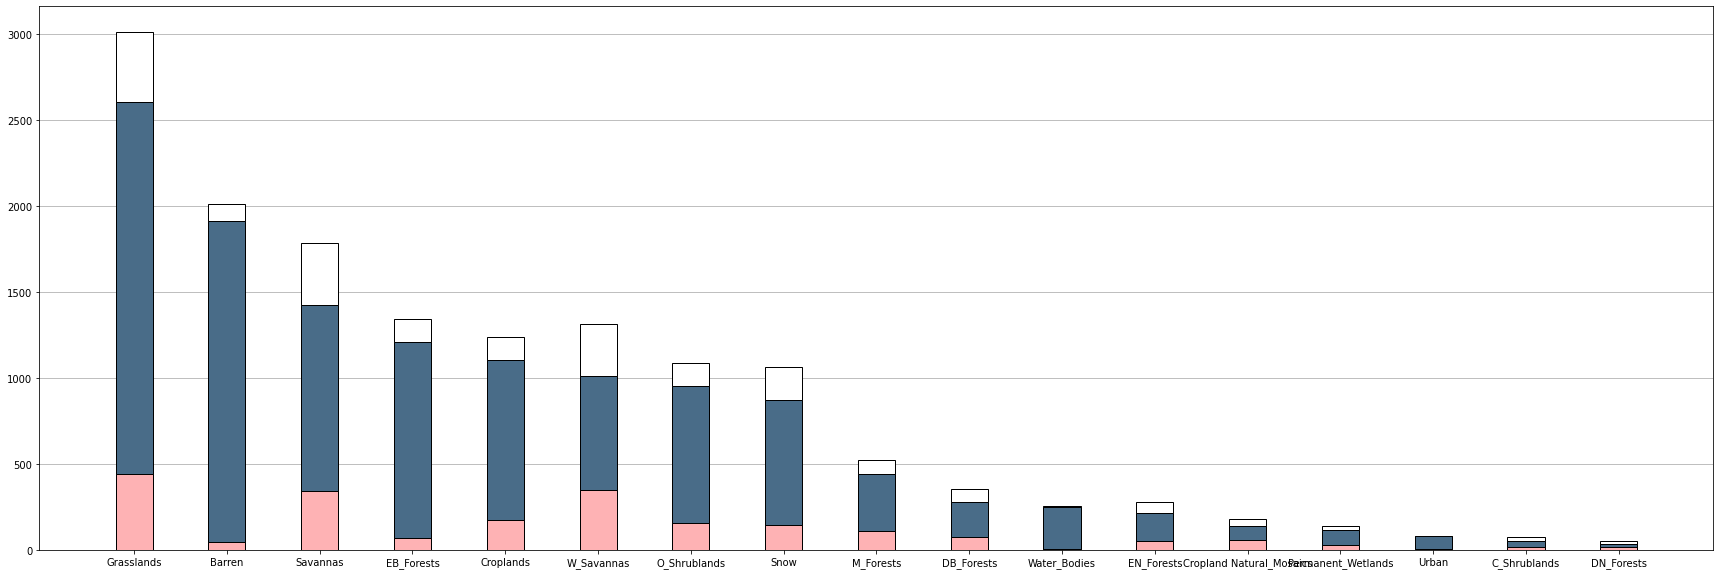

In [704]:
#landcover面积转换
nochange=[transf[i,i]/10000 for i in range(18)]
change_sub=[(np.sum(transf,axis=1)[i]-transf[i,i])/10000 for i in range(18)]
change_add=[(np.sum(transf,axis=0)[i]-transf[i,i])/10000 for i in range(18)]
    # for i in range(18):
        
    #     print(i,type_code[i],change_sub[i],nochange[i],change_add[i])
    
ii=[9,15,8,1,11,7,6,17,4,3,16,0,13,10,12,5,2] 
    
change_add2=[]
change_sub2=[]
nochange2=[]
label=[]
for i in ii:
    change_add2.append(change_add[i])
    change_sub2.append(change_sub[i])
    nochange2.append(nochange[i])
    label.append(type_code[i])
    print(type_code[i],change_sub[i],nochange[i],change_add[i])
    
kk=[nochange2[i]+change_add2[i] for i in range(17)]
plt.figure(figsize=(30,10))
plt.bar(label,change_add2,width=0.4,label='NO',color='#FEB2B4',edgecolor='black',zorder=5)
plt.bar(label,nochange2,width=0.4,bottom=change_add2,label='NO2',color='#496C88',edgecolor='black',zorder=5)
plt.bar(label,change_sub2,width=0.4,bottom=kk,label='NO2',color='white',edgecolor='black',zorder=5)
plt.grid(b=None, which='major', axis='y', )
plt.savefig('bar1.png', dpi=600)
plt.show()

In [707]:
print('单位:e4 km2')
print('总面积：',(np.array(nochange2).sum()+np.array(change_add2).sum()))
print('土地类型改变的区域的面积:',np.array(change_add2).sum())
print('土地类型未改变的区域的面积:',np.array(nochange2).sum())
print('土地类型改变的区域的面积比例：',np.array(change_add2).sum()/(np.array(nochange2).sum()+np.array(change_add2).sum()))

单位:e4 km2
总面积： 12697.489884375
土地类型改变的区域的面积: 2092.6649140624995
土地类型未改变的区域的面积: 10604.8249703125
土地类型改变的区域的面积比例： 0.16480933894167898


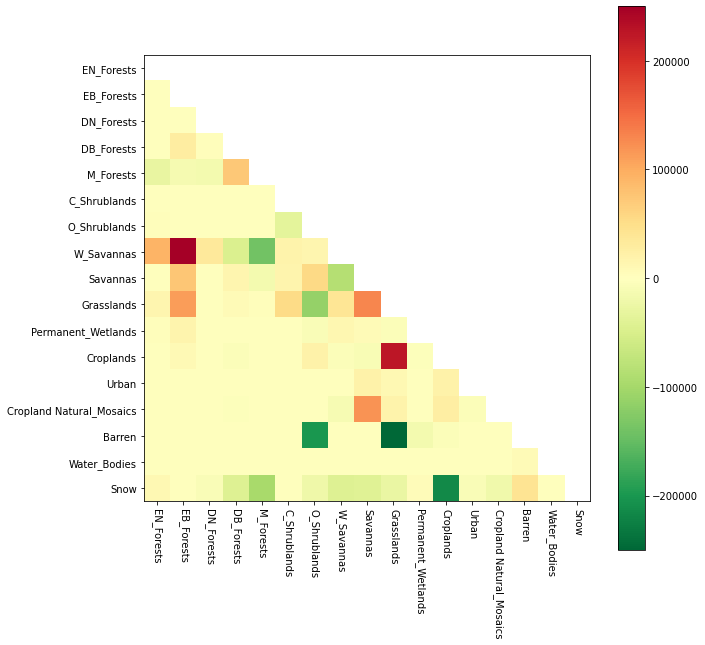

In [708]:
transf2=transf.copy()
transf22=np.zeros((18,18))
for i in range(18):
    transf22[i,i]=0
for x in range(18):
    for y in range(18):
        transf22[x,y]=(transf2[y,x]-transf2[x,y])
        transf22[y,x]=0
transf22[transf22==0]=np.nan
transf3=np.zeros((17,17))
transf3[:14,:14]=transf22[:14,:14]
transf3[14:,:14]=transf22[15:,:14]

transf3[:14,14:]=transf22[:14,15:]
transf3[14:,14:]=transf22[15:,15:]


ll=[type_code[i] for i in range(18) if i!=14]


initial_cmap = cm.get_cmap('RdYlGn')
reversed_cmap = initial_cmap.reversed()
#x to y 减去y to x
plt.figure(figsize=(10,10))
plt.imshow(transf3,vmax=250000,vmin=-250000,cmap=reversed_cmap)
plt.yticks([i for i in range(17)],ll)
plt.xticks([i for i in range(17)],ll)
plt.xticks(rotation=-90)
plt.colorbar()
plt.show()

In [713]:
from tool import *
WB_sky_fraction=torch.load("/data/hk/albedo/white_sky_fraction/white_sky_fraction.pth")
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
stat={}
for month in range(1,13):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
    for year in [2001,2020]:
        types_stat=[]
        types_stat_albedo=[]
        sw=torch.load(f"/data/hk/albedo/SW_MERRA2/{month}_SW_1degree.tif")
        for type in landtypes:
            now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
            month_time=(now+relativedelta(months=1)-now).total_seconds()
            bs=NC.variables[f'albedo_BSA_shortwave-{type}'][year-2001]
            ws=NC.variables[f'albedo_WSA_shortwave-{type}'][year-2001]
            area_type=NC.variables[f'area-{type}'][year-2001] 
            area_land=NC.variables[f'area-land'][year-2001] 
            wf=WB_sky_fraction[(year-2001)*12+month-1]
            # area=NC.variables['area-grid'][year-2001]
            types_stat.append(((ws*wf+bs*(1-wf))/1000)*1e6*sw*month_time)
            types_stat_albedo.append(((ws*wf+bs*(1-wf))/1000))
                            #   (1-(ws*wf+bs*(1-wf))/1000)*area_type*1e6*month_time
            # types_stat.append((ws*wf+bs*(1-wf))*area_type)
        types_stat=np.stack(types_stat)
        types_stat_albedo=np.stack(types_stat_albedo)
        stat[f'{year}-{month}']=types_stat  
        stat[f'{year}-{month}-albedo']=types_stat_albedo
    NC.close()  
    
    
a=[]
for m in range(1,13):
    exp1_2020=np.expand_dims(stat[f'2020-{m}'],0).repeat(18,axis=0)
    exp0_2001=np.expand_dims(stat[f'2001-{m}'],1).repeat(18,axis=1)
    dif_rf=(exp0_2001-exp1_2020).transpose((2,3,0,1))*data_m[m-1]
    a.append(dif_rf[24:-24])
# a+=[np.nansum(dif_rf[24:-24])]    
print('RF all:',np.nansum(np.array(a))/365/24/3600/5.1e8/1e6)

RF all: -0.1836366188207454


In [714]:
a_y=np.stack(a,axis=0)
a_y=np.nansum(a_y,axis=0)
a_transf=np.sum(np.sum(a_y,axis=0),axis=0)
#nochange区域辐射强迫
nc=0
for i in range(18):
    nc+=a_transf[i,i]
print('nochange area RF:',nc/365/24/3600/5.1e8/1e6)
print('change area RF:',a_transf.sum()/365/24/3600/5.1e8/1e6-nc/365/24/3600/5.1e8/1e6)

nochange area RF: -0.17415776410089268
change area RF: -0.009478994727899148


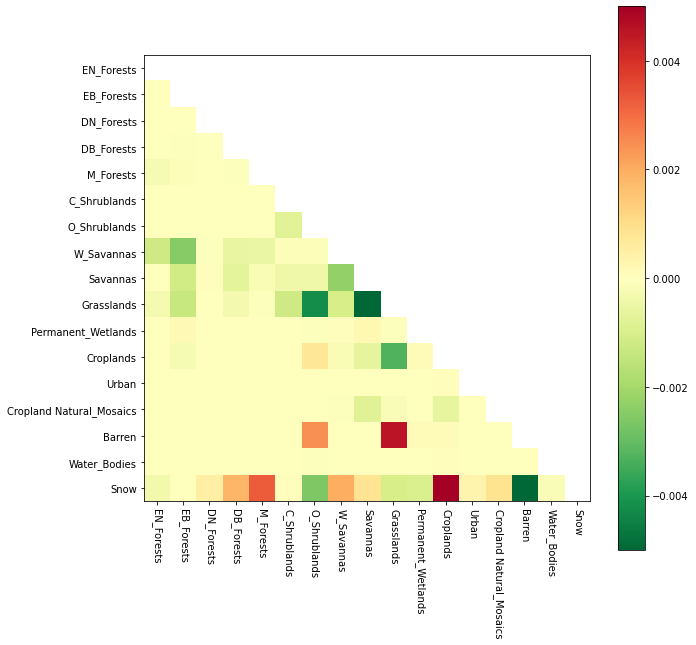

In [715]:
transf2=a_transf.copy()
transf2=transf2/365/24/3600/5.1e8/1e6
transf22=np.zeros((18,18))
for i in range(18):
    transf22[i,i]=0
for x in range(18):
    for y in range(18):
        transf22[x,y]=(transf2[x,y]+transf2[y,x])
        transf22[y,x]=0
transf22[transf22==0]=np.nan
transf3=np.zeros((17,17))
transf3[:14,:14]=transf22[:14,:14]
transf3[14:,:14]=transf22[15:,:14]

transf3[:14,14:]=transf22[:14,15:]
transf3[14:,14:]=transf22[15:,15:]

#A/B转换造成的辐射强迫
from matplotlib import cm
ll=[type_code[i] for i in range(18) if i!=14]
initial_cmap = cm.get_cmap('RdYlGn')
reversed_cmap = initial_cmap.reversed()
plt.figure(figsize=(10,10))
plt.imshow(transf3,vmax=0.005,vmin=-0.005,cmap=reversed_cmap)
plt.yticks([i for i in range(17)],ll)
plt.xticks([i for i in range(17)],ll)
plt.xticks(rotation=-90)
plt.colorbar()
plt.show()

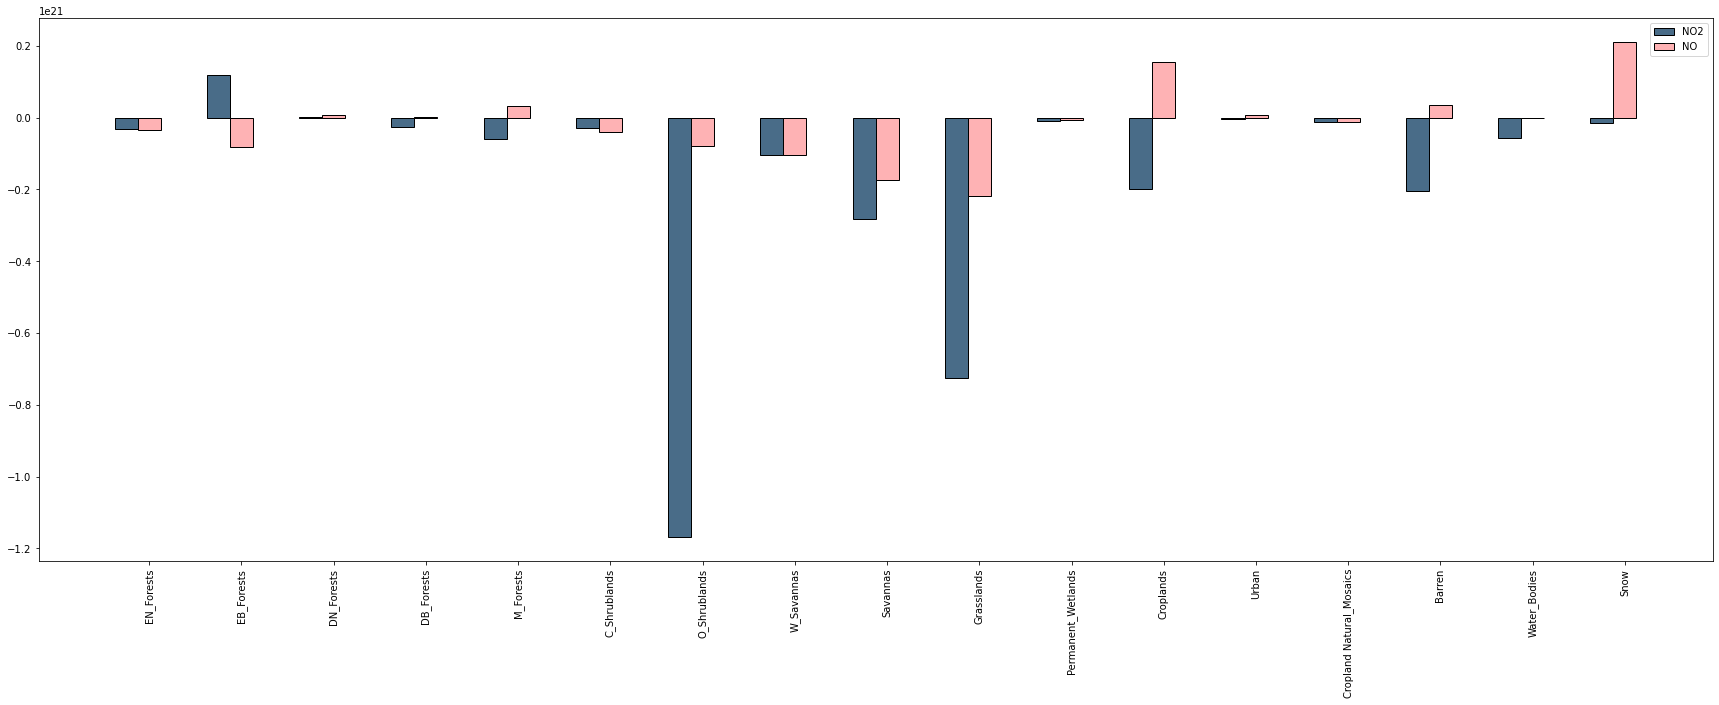

In [716]:
#蓝色nochange RF，粉色change RF
xticks = np.arange(17)
add=[a_transf[:,i].sum()-a_transf[i,i] for i in range(18) if i!=14]
sub=[a_transf[i,:].sum()-a_transf[i,i] for i in range(18) if i!=14]
noc=[a_transf[i,i] for i in range(18) if i!=14]
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(xticks , noc,width=0.25,label='NO2',color='#496C88',edgecolor='black',zorder=5)
ax.bar(xticks+0.25, np.array(add)+np.array(sub),width=0.25,label='NO',color='#FEB2B4',edgecolor='black',zorder=5)
ax.legend()
ax.set_xticks(xticks + 0.25)
ax.set_xticklabels(ll)
plt.xticks(rotation=90)
plt.show()